In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets




In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Data loading and variable declaration

In [3]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


### Define and show widgets
Using ipython widgets create and show widgets for data display option
- Could add observers for each widget to run the data processing step

In [4]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('chrimson', 'jaws', 'mcherry'), value='chrimson')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process data based on widget choice
From each widget obtain the selection choice and process the data.

In [ ]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, opto_zone_avg, control_zone_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]


# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates






### Place field Shifts
how much the place field shifts from session2 to session3 - does the OLM opto leave place cells that shift their place fields less?

> *note that this is place cells vs their place field shift regardless of if its a place cell or not.*

In [12]:
# to compare the rates shift between session2 and session3 need to exclude cells that dont have a ratemap in session3
# creates a list of rates dictionaries that contatin rates only if there is a rate in the last session (index 2) 
retained_place_rates = [df[(rates_to_plot[2].sum(axis=1) > 0).values] for df in rates_to_plot]


binwidth = 2.72 #width of bin in cms

place_rates_retained_centers = [get_placecell_centers(df) for df in retained_place_rates]

optozone_rates = []
controlzone_rates = []

for i in range(len(retained_place_rates)):
    sort_by_place = place_rates_retained_centers[sort_by_index]
    retained_rates = np.array(retained_place_rates[i])
 
    optozone_rates.append(retained_rates[(sort_by_place >= opto_bins[0]) & (sort_by_place <= opto_bins[1])])
    controlzone_rates.append(retained_rates[(sort_by_place >= control_bins[0]) & (sort_by_place <= control_bins[1])])


opto_zone_centers = [np.argmax(rates, axis=1) for rates in optozone_rates]
control_zone_centers = [np.argmax(rates, axis=1) for rates in controlzone_rates]

opto_place_shift = (opto_zone_centers[1]-opto_zone_centers[2])*binwidth
control_place_shift = (control_zone_centers[1]-control_zone_centers[2])*binwidth


# create a random shuffle of the spatial 
random.seed(42)
combined_centers =  np.concatenate((control_zone_centers[1], opto_zone_centers[1]), axis = 0)
random_bins = [random.randint(0, 39) for _ in range(len(combined_centers))]

# Create DataFrame from the Series
place_shifts = pd.DataFrame({'Control-zone': pd.Series(control_place_shift), 'Opto-zone': pd.Series(opto_place_shift)})
shuff_shifts = pd.DataFrame({'Shuffled': pd.Series((combined_centers - random_bins)*binwidth)})


In [ ]:
line_thickness = 3
plot_lines = line_thickness /1.5
point_size = 5
fontsize_scale = 3
group_spacing = 0.2
plot_type = 'barplot'

sns.set_theme(style="ticks", font='Arial', font_scale=fontsize_scale)

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(12, 7))


new_palette = []
palette_div = 3
palette = sns.color_palette('mako', palette_div)
new_palette.append(palette[0])
new_palette.append(palette[palette_div-1])
new_palette_alpha = [t + (0.5,) for t in new_palette]

# Creating a figure and specifying a grid layout
sns.kdeplot(data=place_shifts,
    fill=True, 
    common_norm=False, 
    palette=new_palette,
    alpha=0.75,
    ax=ax1, 
    legend = False)

sns.kdeplot(data=place_shifts,
    palette = ['black','black'],
    alpha=0.75,
    common_norm=False,
    linewidth = plot_lines, 
    ax=ax1, 
    legend = False)

sns.kdeplot(data=shuff_shifts, 
    palette="gray", 
    linestyle='--',
    linewidth = plot_lines, 
    ax = ax1,
    legend = False)

# sns.rugplot(data=place_shifts, 
#     height=0.1, 
#     palette=new_palette,
#     linewidth = 1)

plt.legend([],[], frameon=False)
#ax1.legend(labels=['Opto','Controlzone', 'Shuffled'])
ax1.set(xlabel='Place field shift (cm)', ylabel='Probability density',xlim=[-80, 80],ylim=[0, 0.05])


# get the stats for the values
t_val, p_val = stats.ttest_ind(np.abs(place_shifts['Control-zone'].dropna()),np.abs(place_shifts['Opto-zone'].dropna()))
pval_stars = get_significance_stars(p_val)

if plot_type == 'boxplot':
    # Create the box plot with error bars
    sns.boxplot(data=np.abs(place_shifts), 
                showfliers = False,
                palette=new_palette,
                linewidth = line_thickness/2,
                width=0.4,ax=ax2)
elif plot_type == 'barplot':
    
    # Create the bar plot with error bars
    sns.barplot(data=np.abs(place_shifts), 
                palette=new_palette,
                linewidth = plot_lines,
                width=0.5,
                errorbar='se', 
                capsize=0.25, 
                err_kws={'linewidth': plot_lines,'color': 'black'}, 
                edgecolor = 'black',
                ax=ax2)

# Change the border color of the bars
new_palette_alpha = [color + (0.5,) for color in new_palette]
for i, patch in enumerate(ax2.patches):
    patch.set_edgecolor('black')
    patch.set_linewidth(plot_lines)
    patch.set_facecolor(new_palette_alpha[i])
    
# add a swarm plot to the bars
sns.swarmplot(data=np.abs(place_shifts),
              palette=new_palette, 
              size = point_size, 
              ax=ax2)
ax2.set(ylabel='Placefield shift (cm)')

# add the significance values to the bar 
max_val = np.max(np.abs(place_shifts[['Control-zone',	'Opto-zone']]))+5
plt.plot([0,1],[max_val+0.2,max_val+0.2],color='black', linewidth=line_thickness)
plt.text(0.5, max_val+0.25, f'{pval_stars}', ha='center')


# Change the thickness of the axis lines
ax1.spines['bottom'].set_linewidth(line_thickness)  # bottom axis
ax1.spines['left'].set_linewidth(line_thickness)  # left axis
ax1.tick_params(axis='both', which='major', width=line_thickness, length=10)
ax1.set_ylim([0, 0.04])

ax2.spines['bottom'].set_linewidth(0)  # bottom axis
ax2.spines['left'].set_linewidth(line_thickness)  # left axis
ax2.tick_params(axis='y', which='major', width=line_thickness, length=10)
ax2.tick_params(axis='x', width=0)
ax2.set_xticks([0, 1], ["Control \nZone", "Opto \nZone"])
ax2.set_ylim([-1, 85])
ax2.set_xlim([-0.5, 1.5])


sns.despine()
# Adjust layout and spacing
plt.tight_layout()




In [9]:
joint_pal = [['#693ca3', '#3ebec9'], ['#693ca3', '#eb6c9c']]
joint_pal_point = [['#7c5fa3', '#abeff5'], ['#7c5fa3', '#e38dae']]

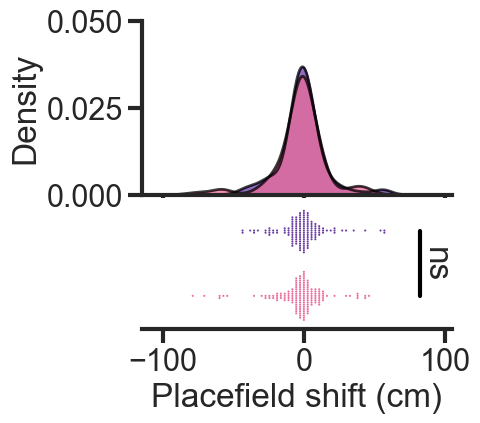

In [10]:
pallette = ['#eb6c9c', '#693ca3']
#pallette = purple_green_pallette
line_thickness = 3
plot_lines = line_thickness /1.5
point_size = 1.5
#point_size = 5.4
fontsize_scale = 2

# get the stats for the values
t_val, p_val = stats.ttest_ind(np.abs(place_shifts['Control-zone'].dropna()),np.abs(place_shifts['Opto-zone'].dropna()))
pval_stars = get_significance_stars(p_val)


sns.set_theme(style="ticks", font='Arial', font_scale=fontsize_scale)

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4, 4), sharex=True,gridspec_kw={'height_ratios': [2, 1.5]})

# KDE plot on the first subplot (top)
sns.kdeplot(data=place_shifts,
    fill=True, 
    common_norm=False, 
    palette=pallette,
    alpha=0.75,
    hue_order=['Opto-zone', 'Control-zone'],
    ax=ax1, 
    legend = False)

sns.kdeplot(data=place_shifts,
    palette = ['black','black'],
    alpha=0.75,
    common_norm=False,
    linewidth = plot_lines, 
    ax=ax1, 
    legend = False)

# sns.kdeplot(data=shuff_shifts, 
#     palette="gray", 
#     linestyle='--',
#     linewidth = plot_lines, 
#     ax = ax1,
#     legend = False)

#pval_stars = 'ns'
# add the significance values to the bar 
max_val = np.max(place_shifts[['Control-zone',	'Opto-zone']])+25
plt.plot([max_val+0.2,max_val+0.2],[0,1],color='black', linewidth=line_thickness)
plt.text(max_val, 0.5, f'{pval_stars}', va='center', rotation=270)

sns.swarmplot(data=place_shifts,palette=pallette, size = point_size, ax=ax2,orient='h', dodge=False, hue_order=['Opto-zone', 'Control-zone'])
ax2.set(xlabel='Placefield shift (cm)')





# Change the thickness of the axis lines
ax1.spines['bottom'].set_linewidth(line_thickness)  # bottom axis
ax1.spines['left'].set_linewidth(line_thickness)  # left axis
ax1.tick_params(axis='both', which='major', width=line_thickness, length=5)
ax1.tick_params(axis='y', length = 10)
ax1.set_xlabel('')
ax1.set_xlim([-115, 105])
ax1.set_ylim([0, 0.05])

ax2.spines['bottom'].set_linewidth(line_thickness)  # bottom axis
ax2.spines['left'].set_linewidth(0)  # left axis
ax2.tick_params(axis='x', which='major', width=line_thickness, length=10)
ax2.set_yticks([0, 1],[" ", " "])  # Just for the two groups
ax2.tick_params(axis='y', which='major', width=0, length=10)

#space between the plots reduce a little bit 
fig.subplots_adjust(hspace=0.02)

sns.despine()
#plt.tight_layout()


# plt.rcParams["font.family"] = "Arial"
# plt.rcParams['svg.fonttype'] = 'none'
# save_path = f"../output_figs/placefield_shifts/novel_mcherry_opto_shifts.svg"
# fig.savefig(save_path, format='svg')


'../output_figs/placefield_shifts/opto-novel_Feild_shifts_vert.svg'